###  1 INTRODUCTION

1.1 GOALS OF PAPER:
The goal of the project is to analyze the
efficiency of a Deep Belief Network and
Feed-Forward Neural Network. Further
examination on their resilience to noise in
the data and to adversarial attacks will be
also carried out.


In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from DBN import DBN
from tqdm.notebook import tqdm
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import time

print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


1.2 OVERVIEW OF THE DATASET

DOWNLOADING THE DATA SPLITTED IN TRAINING AND TEST SET

In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',split= 'letters', train =True, download=True,transform=tv.transforms.ToTensor())
emnist_test = tv.datasets.EMNIST('data/',split= 'letters', train = False, download=True,transform=tv.transforms.ToTensor())

SIZE OF THE TWO SETS

In [ ]:
print("The size of the training set is: ",emnist_train.data.shape)
print("The size of the test set is: ",emnist_test.data.shape)

The size of the training set is:  torch.Size([124800, 28, 28])
The size of the test set is:  torch.Size([20800, 28, 28])


1.3 PREPROCESSING:
Each single pixel value falls within [0,255]
range where 0 represents “black” and 255
reprepresents “white”. Since the model
under examination is a DBN these values
will be scaled down to the range [0,1].


In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)
emnist_train.targets -= 1
emnist_test.targets -= 1

targe_train = emnist_train.targets.numpy()
targe_test = emnist_test.targets.numpy()

emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

IMAGES DISPLAYED

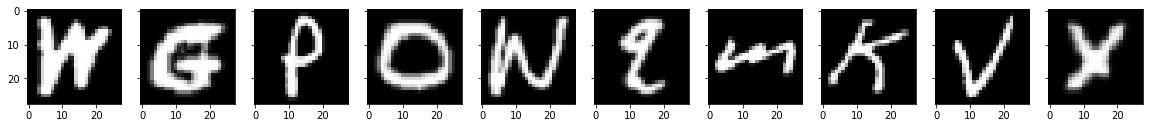

In [ ]:
targets_for_printing = emnist_train.targets
data_for_printing = emnist_train.data
targets_for_printing = targets_for_printing.to('cpu').numpy()
data_for_printing = data_for_printing.to('cpu').numpy()

num_subplots = 10 ; n_cols = 10 ; n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20,20))
for i in range(num_subplots):
  col = i % n_cols
  axes[col].imshow(data_for_printing[i].reshape((28,28)).T, cmap=plt.cm.gray)

### 2. UNSUPERVISED LEARNING:

2.1 BRIEF DESCRIPTION OF THE
MODEL
Deep Belief Networks also referred to with
the acronym D.B.N. are generative models
and as such they build representations of
the data they get as input in an
unsupervised learning way.
A DBN is constituted by a stack of
Restricted Boltzmann Machines (R.B.M.)
which are stochastic recurrent networks;
more specifically they are probabilistic
graphical models where each neuron
activation level represents a probability.
The term “restricted” refers to the absence of intralayer connections between
neurons.
Each RBM is trained aiming to maximize
the likelihood function via an algorithm
known as “Contrastive Divergence”,
consequently the whole DBN is trained in
a greedy way.
The representations made by the model
are used to classify the original images.
This classification is carried out with a
linear classifier that encodes the
categories trained with supervised
learning.
The linear classifier that is fully connected
to the deepest hidden layer investigates
the task performance whereas read-outs
at previous hidden layers investigate how
well each of them makes representations.
An increasing accuracy across the linear
read-outs indicates that the
representations get progressively more
disentangled.
Ideally, the intention would be to structure
a DBN that makes representation of the
data it has been fed on in an hierarchical
fashion. Therefore the representations
outputted by the first RBM are expected to
be higher level than the ones produced by
the last one.
To facilitate this, the DBN will be
structured having an increasing number of
neurons at each hidden layer of the
RBMs.


2.2 SETTING UP THE PARAMETERS
Provided that the DBN under analysis
consist of a stack of three RBMs the main
parameters to focus on are the:
- the number of neurons of the
hidden layer of each RBM: having
a network with too many neurons
could require a while for the
training to be completed and it
could also lead to overfitting.
Therefore, a reasonable number of
neurons is to be chosen.

- the number of epochs the DBN is
trained over
- the batch size: larger batch size
may speed up the training but
usually leads to worse model
performance if compared to
smaller ones.
- learning rate: if it is too small the
training phase is faster but there is
the risk of overshooting the
minima, if it is too small instead the
training is too slow.

The performance of the model highly
depends on the structure of the network,
thus some reasoning about the matter is
required. It can be proved that the same
DBN structured with 400 neurons in the
hidden layer of the first RBM,500 in the
one of the second RBM and 800 neurons
in the one of the third RBM reaches a
good level of accuracy over the MNIST
dataset.
The MNIST dataset, though, consists of
ten classes, one for each digit whereas
the EMNIST- letters one has more of the
double of the classes, therefore a bigger
number of neurons might be required to
reach a similar performance.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 600, 900],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

num_epochs = 50
batch_size = 50

s_t_dbn = time.time()
dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

e_t_dbn = time.time()
required_training_time_dbn_minutes = (e_t_dbn-s_t_dbn)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6890     |0.0398       |437.0658   |6.3127     |
|20    |0.6841     |0.0391       |419.6833   |6.8668     |
|30    |0.6919     |0.0401       |403.0439   |6.5871     |
|40    |0.6968     |0.0402       |390.0044   |6.3110     |
|50    |0.7044     |0.0402       |380.5019   |6.2505     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5194     |0.0234       |221.3031   |3.0583     |
|20    |0.5107     |0.0244       |219.2387   |2.9048     |
|30    |0.5085     |0.0235       |218.3343   |2.7747     |
|40    |0.5069     |0.0233       |217.6011   |2.5952     |
|50    |0.5074     |0.0234       |217.8345   |2.9789     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.3100     |0.0141       |262.6650   |3.4187     |
|20    |0.3078     |0.0145       |262.5072   |3.327

In [ ]:
required_training_time_dbn_minutes/60

12.545533088843028

Instantiate the class to build the linear classifiers

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 26)

  def forward(self, x):
    return self.linear(x)

The following cell instead initialize the three read-out for future use

In [ ]:
layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size_1).to(device)

layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size_2).to(device)

layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size_3).to(device)

In [ ]:
def layer_neurons(l_s_1,l_s_2,l_s_3):
  bin_pos = np.arange(0,3)
  layer_lab = ['hid_1','hid_2','hid_3']
  layers = [l_s_1,l_s_2,l_s_3]
  plt.barh(bin_pos,layers)
  plt.yticks(bin_pos,layer_lab)

400
600
900


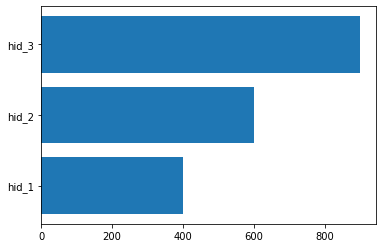

In [ ]:
layer_neurons(layer_size_1,layer_size_2,layer_size_3) ; print(layer_size_1) ; print(layer_size_2); print(layer_size_3)

In the cell below the training function for the linear read_outs is defined.

In [ ]:
def train(network, input, epochs=2000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  loss_vec = []
  epochs_vec = []
  

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))
    loss_vec.append(loss.to('cpu').tolist())
    epochs_vec.append(epoch)

  return loss_vec

Calling the following function will allow us to get the representation of the layers

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device) 
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device) ; hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device) ; hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
def loss_curve_dbn(t1,t2,t3,epochs):
  ipq = np.arange(1,epochs+1
                  )
  plt.plot(
      ipq,
      t1
  )
  
  plt.plot(
      ipq,
      t2
  )
  
  plt.plot(
      ipq,
      t3
  )
  plt.title(f'Training: Loss as number of epochs epochs increases')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.grid()
  plt.legend(['rbm_1', "rbm_2", "rbm_3"], loc = 'best')
  plt.show()

In [ ]:
if hidden_repr_layer_1.is_cuda == False:
  hidden_repr_layer_1 = hidden_repr_layer_1.to('cuda')
if hidden_repr_layer_2.is_cuda == False:
  hidden_repr_layer_2 = hidden_repr_layer_2.to('cuda')
if hidden_repr_layer_3.is_cuda == False:
  hidden_repr_layer_3 = hidden_repr_layer_3.to('cuda')
if emnist_train.targets.is_cuda == False: 
  emnist_train.targets = emnist_train.targets.to('cuda')

HERE TRAIN THE LINEAR CLASSIFIERS

In [ ]:
t1 = train(linear1, hidden_repr_layer_1) ; t2 = train(linear2, hidden_repr_layer_2) ; t3 = train(linear3, hidden_repr_layer_3)

epoch :   1/2000, loss = 3.2594
epoch : 101/2000, loss = 2.4946
epoch : 201/2000, loss = 2.0356
epoch : 301/2000, loss = 1.7572
epoch : 401/2000, loss = 1.5788
epoch : 501/2000, loss = 1.4565
epoch : 601/2000, loss = 1.3675
epoch : 701/2000, loss = 1.2992
epoch : 801/2000, loss = 1.2448
epoch : 901/2000, loss = 1.2000
epoch : 1001/2000, loss = 1.1623
epoch : 1101/2000, loss = 1.1298
epoch : 1201/2000, loss = 1.1015
epoch : 1301/2000, loss = 1.0764
epoch : 1401/2000, loss = 1.0540
epoch : 1501/2000, loss = 1.0338
epoch : 1601/2000, loss = 1.0154
epoch : 1701/2000, loss = 0.9985
epoch : 1801/2000, loss = 0.9830
epoch : 1901/2000, loss = 0.9687
epoch :   1/2000, loss = 3.2615
epoch : 101/2000, loss = 2.3516
epoch : 201/2000, loss = 1.8729
epoch : 301/2000, loss = 1.6101
epoch : 401/2000, loss = 1.4499
epoch : 501/2000, loss = 1.3418
epoch : 601/2000, loss = 1.2631
epoch : 701/2000, loss = 1.2024
epoch : 801/2000, loss = 1.1535
epoch : 901/2000, loss = 1.1129
epoch : 1001/2000, loss = 1.07

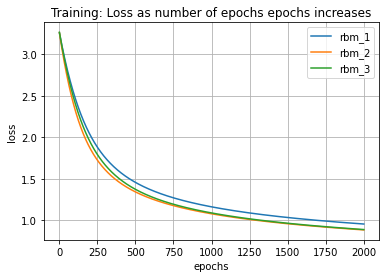

In [ ]:
loss_curve_dbn(t1,t2,t3,2000)

In [ ]:
if emnist_test.data.is_cuda == False:
  emnist_test.data = emnist_test.data.to('cuda')

Let's now extract the representation of the test set

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device) ; 
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device) 
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

With the cell below we store the predictions of the classfiers in the three variables.

In [ ]:
predictions_test1 = linear1(hidden_repr_layer_1_test) ; predictions_test2 = linear2(hidden_repr_layer_2_test) ; predictions_test3 = linear3(hidden_repr_layer_3_test)

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
accuracy_lr_1 = compute_accuracy(predictions_test1, emnist_test.targets) 
accuracy_lr_2 = compute_accuracy(predictions_test2, emnist_test.targets) 
accuracy_lr_3 = compute_accuracy(predictions_test3, emnist_test.targets)

Let's the level of accuracy are reached for each classifier

In [ ]:
print("Accuracy of the first classifier:",accuracy_lr_1) ; print("Accuracy of the second classifier:",accuracy_lr_2) ; print("Accuracy of the third classifier:",accuracy_lr_3)

Accuracy of the first classifier: 0.7393268942832947
Accuracy of the second classifier: 0.7558653950691223
Accuracy of the third classifier: 0.7583653926849365


### 3 FURTHER INVESTIGATION OF THE MODEL


3.1 PREDICTION OF EACH LETTER

In [ ]:
def cm_matrix_diag(predictions, targets,range_i,range_f):
  dizionario = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[],20:[],21:[],22:[],23:[],24:[],25:[]}
  for j in range(range_i,range_f):
    ac_j_p= (predictions.max(axis=1).indices[np.where(targe_test == j)] == targets[np.where(targe_test == j)]).sum() /len(targets[np.where(targe_test == j)])
    acc_j_a = (predictions.max(axis=1).indices[np.where(targe_test == j)] == targets[np.where(targe_test == j)]).sum()
    dizionario[j].append((ac_j_p,acc_j_a))
  return dizionario

def from_diz_to_list(diz,range_i,range_f):
  lis = []
  for i in range(range_i,range_f):
    lis.append(diz[i][0][0].item())
  return lis

def errors_bars(e_1,e_2,e_3,range_i,range_f, noise_lev):
  range = range_f-range_i
  x_pos = np.arange(0,2*range,2)
  alfa = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  labels = alfa[range_i:range_f]
  plt.bar(x_pos-0.4,e_1, width=0.4, color='blue', label = 'rbm_1')
  plt.bar(x_pos,e_2,width=0.4, color='aqua', label = 'rbm_2')
  plt.bar(x_pos+0.4,e_3,width=0.4, color = 'forestgreen', label = 'rbm_3')
  plt.xticks(x_pos,labels)
  plt.grid(color = 'b',axis='y')
  plt.title(f'Prediction Accuracy of each single letter {noise_lev}')
  plt.ylabel('Accuracy')
  plt.xlabel('Blue: rbm_1, Azure: rbm_2, Green: rbm_3')
  plt.figure(figsize =(30, 30))

In [ ]:
def errors_bars_rbm_vs_ffnn(e_1,e_2,range_i,range_f,noise=None):
  range = range_f-range_i
  x_pos = np.arange(0,2*range,2)
  alfa = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  labels = alfa[range_i:range_f]
  plt.bar(x_pos-0.2,e_1, width=0.4, color='lime', label = 'rbm_3')
  plt.bar(x_pos+0.2,e_2,width=0.4, color = 'r', label = 'ffnn')
  plt.xticks(x_pos,labels)
  plt.grid(color = 'b',axis='y')
  plt.title(f'Prediction Accuracy of each single letter, noise level: {noise}')
  plt.ylabel('Accuracy')
  plt.xlabel('Green: rbm_3, Red: ffnn')
  plt.figure(figsize =(30, 30))

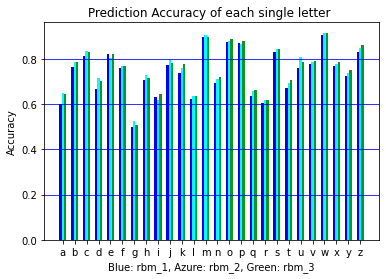

<Figure size 2160x2160 with 0 Axes>

In [ ]:
A = cm_matrix_diag(predictions_test1,emnist_test.targets,0,26)
B = cm_matrix_diag(predictions_test2,emnist_test.targets,0,26)
C = cm_matrix_diag(predictions_test3,emnist_test.targets,0,26)
a = from_diz_to_list(A,0,26)
b = from_diz_to_list(B,0,26)
c = from_diz_to_list(C,0,26)
errors_bars(a,b,c,0,26,'')

As it can be clearly seen from the bar
chart above, the letter which the model
struggles the most with is the “g”, while the
one with it deals the best is the “w”.

3.2 CONFUSION MATRICES

An extensive description of the predictions
made at test time can be represented in
the form of confusion matrices.

In [ ]:
def arg_max_tensor(tensor):
  tensor = tensor.to('cpu').detach().numpy()
  prediz = [np.argmax(i) for i in tensor]
  return prediz

def c_matrix(actual_classes,predicted_targets,title):
  alfa = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  cm = confusion_matrix(actual_classes, predicted_targets)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = alfa)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax)
  
  plt.title(title)
  plt.show()

def from_tensor_to_list(tensor):
  tensor = list(tensor.to('cpu').numpy())
  return tensor

In [ ]:
pred_t1 = arg_max_tensor(predictions_test1)
t1_targ_cm = from_tensor_to_list(emnist_test.targets)

pred_t2 = arg_max_tensor(predictions_test2)
t2_targ_cm = from_tensor_to_list(emnist_test.targets)

pred_t3 = arg_max_tensor(predictions_test3)
t3_targ_cm = from_tensor_to_list(emnist_test.targets)

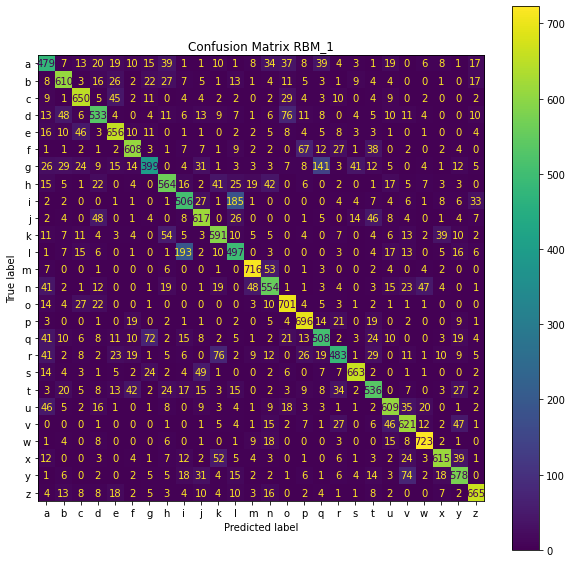

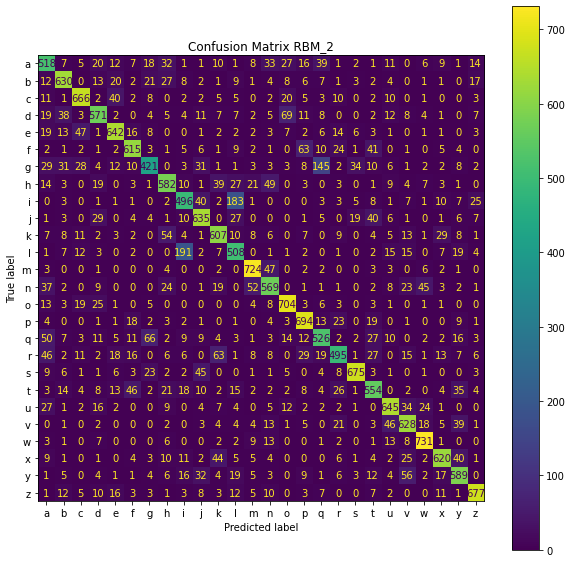

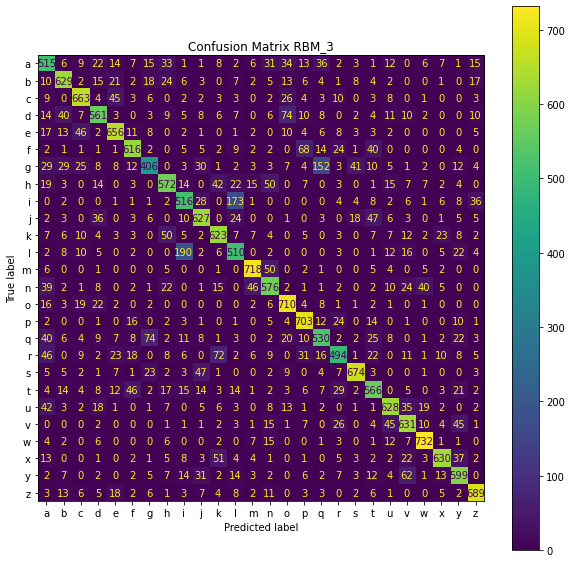

In [ ]:
a = c_matrix(t1_targ_cm,pred_t1,"Confusion Matrix RBM_1")
b = c_matrix(t2_targ_cm,pred_t2,"Confusion Matrix RBM_2")
c = c_matrix(t3_targ_cm,pred_t3,"Confusion Matrix RBM_3")

DISCUSSION:
The matrices show that “i” and “l” are often mistaken for one another; the same thing happens for the letters “q” and “g”. 


LET'S NOW VISUALIZE THE RECEPTIVE FIELDS

### 3.3 VISUALIZING RECEPTIVE FIELDS:
After the model has been trained it is possible to visualize the learned weights. In the images below some of the weights are plotted in cells of 28x28 pixels so that it will be possible to identify which parts of an image trigger the unitt of a specific vector.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights,set_of_neurons):
  num_subplots = 100 
  n_rows_cols = int(math.sqrt(num_subplots)) # =10
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  fig.suptitle(set_of_neurons)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
print(learned_weights_layer_1.shape[0],"x",learned_weights_layer_2.shape[1])
learned_weights_product = apply_min_max_scaler(learned_weights_product)

784 x 600


In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection

learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection

learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)

learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

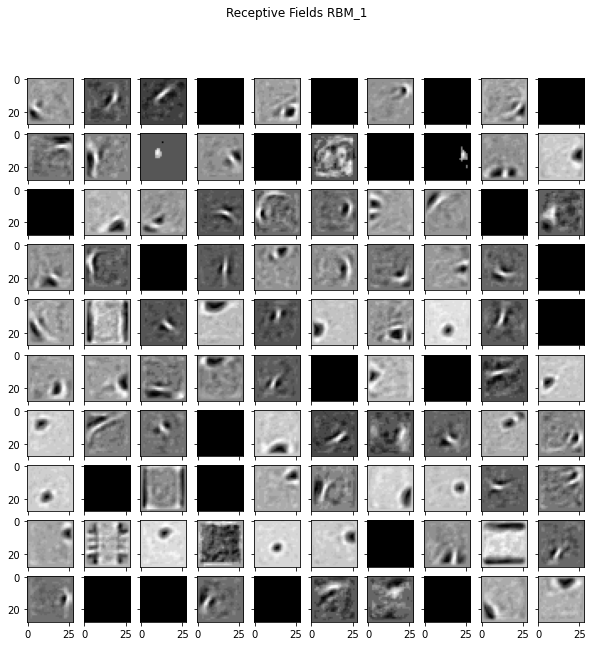

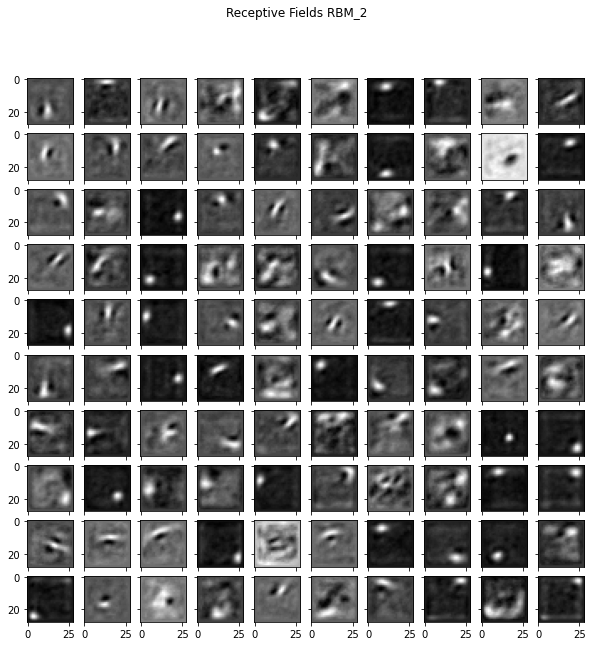

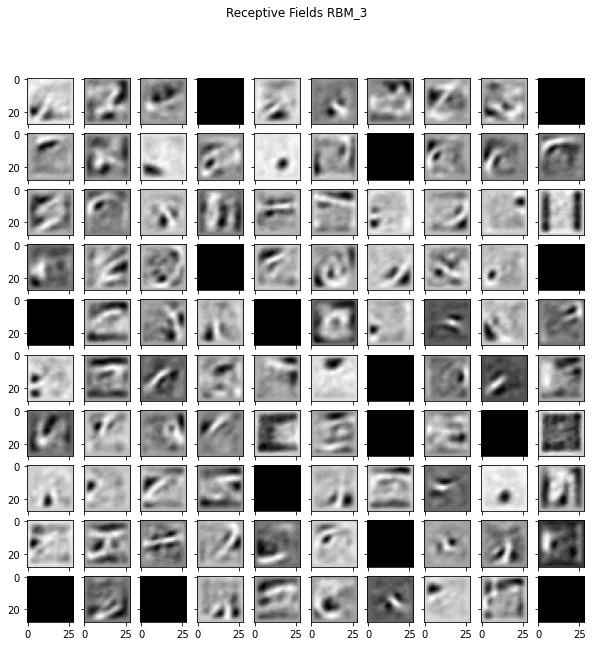

In [ ]:
plot_layer_receptive_fields(learned_weights_layer_1.T, 'Receptive Fields RBM_1')
plot_layer_receptive_fields(learned_weights_product.T,'Receptive Fields RBM_2')
plot_layer_receptive_fields(learned_weights_23_product.T, 'Receptive Fields RBM_3')

In full accordance with what was
mentioned before, the representations
become better and better.

### 3.4 HIERARCHICAL CLUSTERING

Internal representation properties are explorable through plotting their dendrogram.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
def change_targets(labels):
  tens_to_list = labels.tolist()
  list_letter_labels = []
  diZ = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',15:'p',16:'q',17:'r',18:'s',19:'t',20:'u',21:'v',22:'w',23:'x',24:'y',25:'z'}
  for i in tens_to_list:
    list_letter_labels.append(diZ[i])
  return list_letter_labels

In [ ]:
labels = emnist_train.targets.cpu().numpy()
li = change_targets(labels)
alfa = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [ ]:
def get_mask(label):  # we use this function to filter by class
  #trasforma labels in lettere
  return np.array(li) == label  # here you were comparing a list to a string.

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in alfa
  }
def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in alfa])

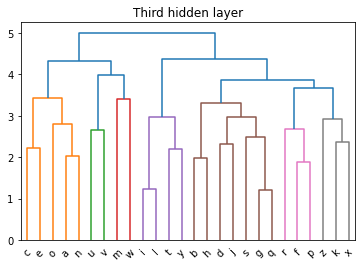

In [ ]:
hidden_representation_np = hidden_repr_layer_3.cpu().numpy()
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=alfa)  # check they are in the correct order here
  ax.set_title(title)
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

DISCUSSION:
The dendrogram above shows how similar
the letters are to each other according to
the DBN. The results seem to be pretty
reasonable. For example the letter “o”
differs from the “c” just for a small arch
that would complete a “c” into an “o” that’s
why they are close in the dendrogram.


### 4. ROBUSTENESS TO THE NOISE

4.1 RANDAM GAUSSIAN NOISE:
Let’s now inject some noise in the images
and then feed the models with them to
examine how resilient the model is to
noisy stimuli.
A tensor whose items come from a normal
distribution of mean 0 and variance 1 is
created, then it is multiplied by the noise
level (ε) and finally the perturbed dataset is
obtained by adding that tensor to the original
data one.

In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  disturbed = emnist_data + random_gaussian_tensor
  return disturbed

In [ ]:
def Change_Targets(labels):
  list_letter_labels = []
  diZ = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',15:'p',16:'q',17:'r',18:'s',19:'t',20:'u',21:'v',22:'w',23:'x',24:'y',25:'z'}
  for i in labels:
    list_letter_labels.append(diZ[i])
  return np.array(list_letter_labels)

def arg_max_tensor(tensor):
  tensor = tensor.to('cpu').detach().numpy()
  prediz = [np.argmax(i) for i in tensor]
  return prediz

def c_matrix_noise(label,title):
  
  lab_effettivi = change_targets(emnist_test.targets)
  
  numerical_labels = arg_max_tensor(label) #pred_rmb_1 == label
  alpha_labels = Change_Targets(numerical_labels)

  cm = confusion_matrix(lab_effettivi, alpha_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = alfa)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax)
  
  plt.title(title)
  plt.show()

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden,predictions_first_hidden_noisy,predictions_second_hidden_noisy,predictions_third_hidden_noisy

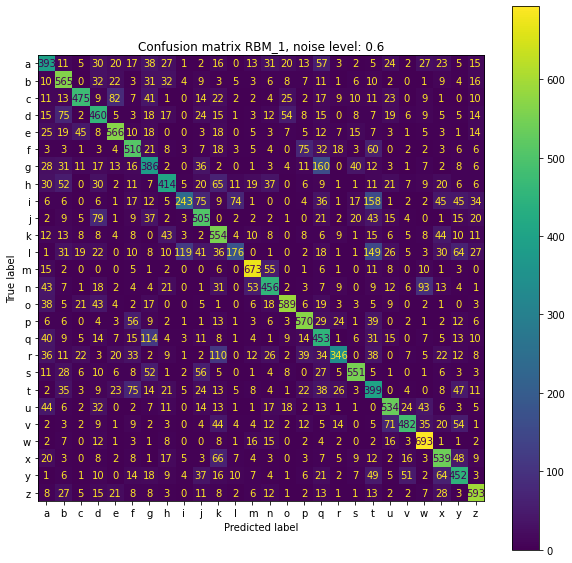

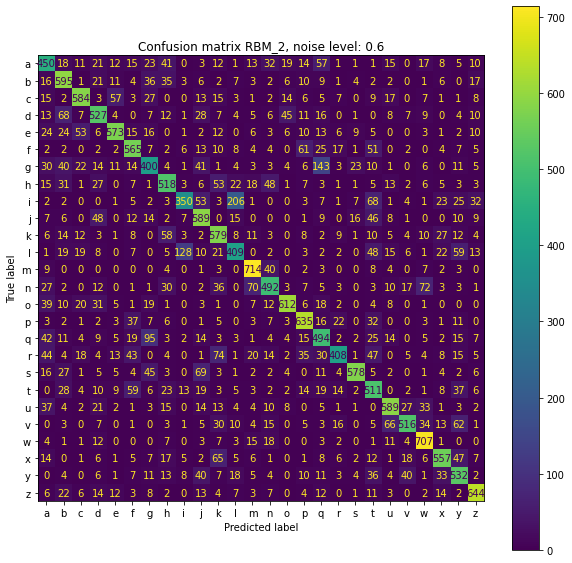

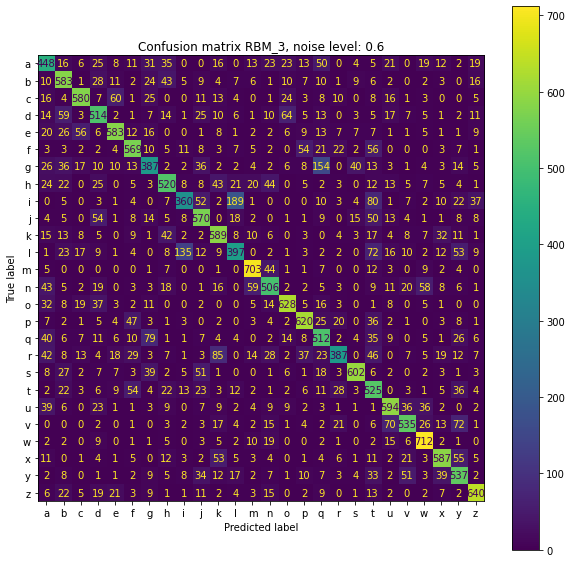

In [ ]:
rbm_1_prede = get_accuracy_values_at_noise_level(0.6)[3]
rbm_2_prede = get_accuracy_values_at_noise_level(0.6)[4]
rbm_3_prede = get_accuracy_values_at_noise_level(0.6)[5]
A = c_matrix_noise(rbm_1_prede,'Confusion matrix RBM_1, noise level: 0.6')
B = c_matrix_noise(rbm_2_prede,'Confusion matrix RBM_2, noise level: 0.6')
C = c_matrix_noise(rbm_3_prede, 'Confusion matrix RBM_3, noise level: 0.6')

### 5. COMPARISON WITH A FEED-FORWARD NEURAL NETWORK

5.1 TRAINING OF FEED FORWARD NEURAL NETWORK

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 26)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
def ffnn_loss(network,epochs):
  ipq = np.arange(1,epochs+1)
  ipq = list(ipq)
  plt.plot(
      ipq,
      FN
  )
  plt.title(f'Training: Loss as the number of epochs increases')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.grid()
  plt.legend(['ffnn'], loc = 'best')
  plt.show()  

In [ ]:
def loss_curves(t1,t2,t3,ffnn,epochs):
  ipq = np.arange(1,epochs+1
                  )
  plt.plot(
      ipq,
      t1
  )
  
  plt.plot(
      ipq,
      t2
  )
  
  plt.plot(
      ipq,
      t3
  )

  plt.plot(
      ipq,
      FN
  )
  
  plt.title(f'Training: Loss as the number of epochs increases')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.grid()
  plt.legend(['rbm_1', "rbm_2", "rbm_3","ffnn"], loc = 'best')
  plt.show()

In [ ]:
emnist_train.data = emnist_train.data.to(device='cuda')
emnist_train.data.is_cuda
emnist_test.data = emnist_test.data.to(device='cuda')
emnist_test.data.is_cuda

True

5.1 TRAINING OF FEED FORWARD:
NEURAL NETWORK
A feed-forward neural network is trained
on the same dataset. The make a fair
comparison
It is trained with the same amount of
epochs and the same size of hidden
neurons.

In [ ]:
ffnn = Feedforward(400,600,900).to(device)
s_t_ffnn = time.time()
FN = train(ffnn, emnist_train.data.reshape((124800, 784)), epochs=2000)
e_t_ffnn = time.time()
required_training_time_ffnn = e_t_ffnn - s_t_ffnn
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))
accuracy_feed_forward = compute_accuracy(predictions_ffnn, emnist_test.targets)
print(f"The accuracy of the Feed-Forward network: ",accuracy_feed_forward)

epoch :   1/2000, loss = 3.2584
epoch : 101/2000, loss = 3.2277
epoch : 201/2000, loss = 3.1071
epoch : 301/2000, loss = 2.4956
epoch : 401/2000, loss = 1.7709
epoch : 501/2000, loss = 1.4821
epoch : 601/2000, loss = 1.3431
epoch : 701/2000, loss = 1.2420
epoch : 801/2000, loss = 1.1637
epoch : 901/2000, loss = 1.1035
epoch : 1001/2000, loss = 1.0430
epoch : 1101/2000, loss = 0.9872
epoch : 1201/2000, loss = 0.9346
epoch : 1301/2000, loss = 0.8846
epoch : 1401/2000, loss = 0.8377
epoch : 1501/2000, loss = 0.7944
epoch : 1601/2000, loss = 0.7550
epoch : 1701/2000, loss = 0.7193
epoch : 1801/2000, loss = 0.6869
epoch : 1901/2000, loss = 0.6575
The accuracy of the Feed-Forward network:  0.811923086643219


5.2 COMPARISON BETWEEN
DEEPEST DBN READ OUT WITH
THE FFNN:
A five 5% gap in accuracy separates
the FFNN and the DBN, but let’s
further investigate it.

In [ ]:
required_training_time_ffnn_minutes = required_training_time_ffnn/60

In [ ]:
required_training_time_ffnn_minutes

8.401715683937073

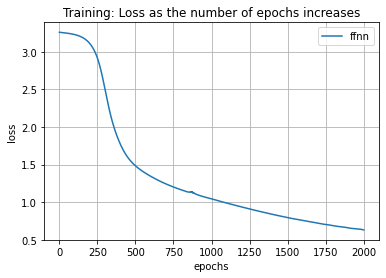

In [ ]:
ffnn_loss(FN, 2000)

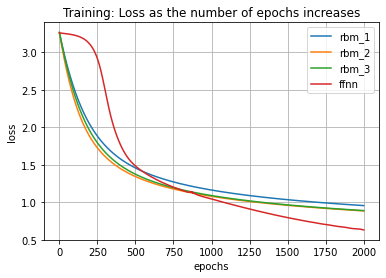

In [ ]:
loss_curves(t1,t2,t3,FN,2000)

The loss relative to the FFNN stalls for
the first two hundred epochs and then
decreases abruptly until the five
hundredth epoch is reached, after that
the loss decreases more gradually.
The loss curves relative to the DBN
instead, go down more smoothly.
However around the thousandth
epoch, these loss curves start to
diverge from the red one.

In [ ]:
emnist_test.data.is_cuda
emnist_test.data = emnist_test.data.to(device)

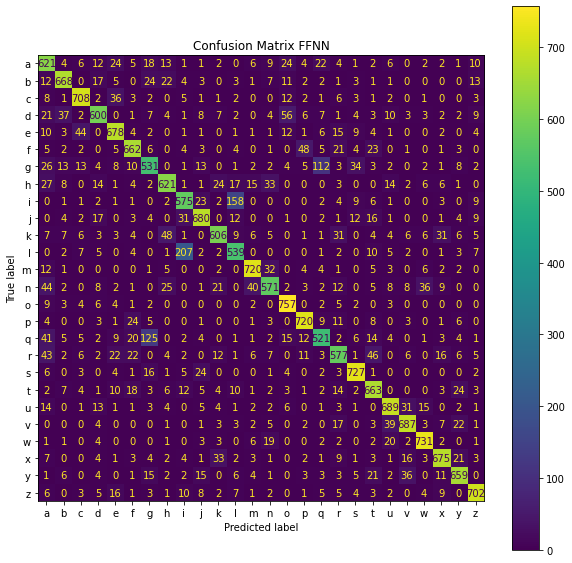

In [ ]:
pred_fn = arg_max_tensor(predictions_ffnn)
fn_targ_cm = from_tensor_to_list(emnist_test.targets)
fn_matrix = c_matrix(fn_targ_cm,pred_fn,"Confusion Matrix FFNN")

In [ ]:
def get_accuracy_values_at_noise_level_ffnn(noise_level):
  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)
  return predictions_ffnn_noisy,accuracy_ffnn

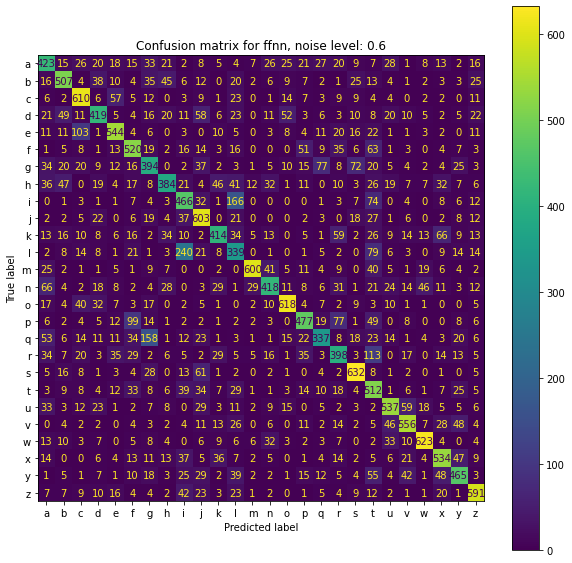

In [ ]:
fn_prede = get_accuracy_values_at_noise_level_ffnn(0.6)[0]
D = c_matrix_noise(fn_prede,'Confusion matrix for ffnn, noise level: 0.6')

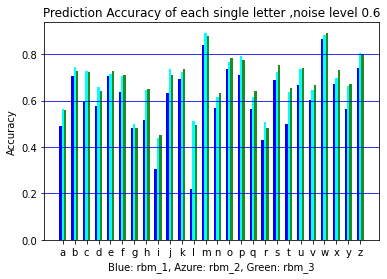

<Figure size 2160x2160 with 0 Axes>

In [ ]:
A_1 = cm_matrix_diag(rbm_1_prede,emnist_test.targets,0,26)
B_1 = cm_matrix_diag(rbm_2_prede,emnist_test.targets,0,26)
C_1 = cm_matrix_diag(rbm_3_prede,emnist_test.targets,0,26)
a_1 = from_diz_to_list(A_1,0,26)
b_1 = from_diz_to_list(B_1,0,26)
c_1 = from_diz_to_list(C_1,0,26)
errors_bars(a_1,b_1,c_1,0,26,',noise level 0.6')

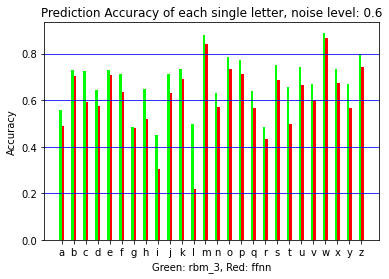

<Figure size 2160x2160 with 0 Axes>

In [ ]:
D_1= cm_matrix_diag(fn_prede,emnist_test.targets,0,26)
d_4 = from_diz_to_list(A_1,0,26)
errors_bars_rbm_vs_ffnn(c_1,d_4,0,26,0.6)

With a noise random gaussian with ε = 0.6
is injected in the model the DBN perform
better than the FFNN, let’s make the
comparison on a wide range of values of ε

5.3 COMPARISON BETWEEN EACH RBN AND THE FFNN: PSYCHOMETRIC CURVE

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []


  for noise_level in noise_levels:
    acc_rbm = get_accuracy_values_at_noise_level(noise_level) # <-----
    acc_ffnn = get_accuracy_values_at_noise_level_ffnn(noise_level)

    accuracy_values_first_hidden.append(acc_rbm[0])
    accuracy_values_second_hidden.append(acc_rbm[1])
    accuracy_values_third_hidden.append(acc_rbm[2])
    accuracy_values_ffnn.append(acc_ffnn[1])


  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

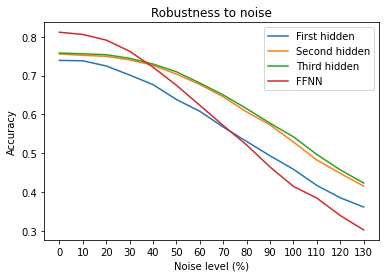

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

The accuracy of the second and third
RBMs remains almost the same for values
of ε smaller than 0.4, that is also the value
of epsilon around which the curve of the
FFNN goes below the curves of the last
two RBMs. For higher levels of noise the
FFNN performance is even worse than the
first RBM.

### 6. ADVERSARIAL ATTACKS

6.1 DEFINITION OF ADVERSARIAL
ATTACK
The noise added to the images in
adversarial attacks is specifically crafted to
confuse the model.
Random gaussian noise is random by
definition so it by no means depends on
the gradient of the cost function.
Conversely adversarial attacks aim to
inject noise in the opposite direction of the
descent of the gradient.
The attack is implemented according to
the following formula, where “x” represents
the data tensor.

𝑥 = 𝑥 + ε 𝑠𝑖𝑔𝑛(∇𝑥(𝑤, 𝑥, 𝑦)).

Adversarial attacks are meant to pass
undetected so usually ε is not very large.

In [ ]:
from pdb import set_trace

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
def label_changer(predi):
  diZ = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',15:'p',16:'q',17:'r',18:'s',19:'t',20:'u',21:'v',22:'w',23:'x',24:'y',25:'z'}
  return diZ[predi]

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

In [ ]:
attacked_ffnn = ffnn
attacked_dbn = dbn_with_readout

DBN

The prediction of the model for the perturbed sample is t.
The prediction of the model for the perturbed sample is h.
The prediction of the model for the perturbed sample is u.
The prediction of the model for the perturbed sample is q.
The prediction of the model for the perturbed sample is k.
The prediction of the model for the perturbed sample is n.
The prediction of the model for the perturbed sample is u.
The prediction of the model for the perturbed sample is w.
The prediction of the model for the perturbed sample is w.
The prediction of the model for the perturbed sample is a.


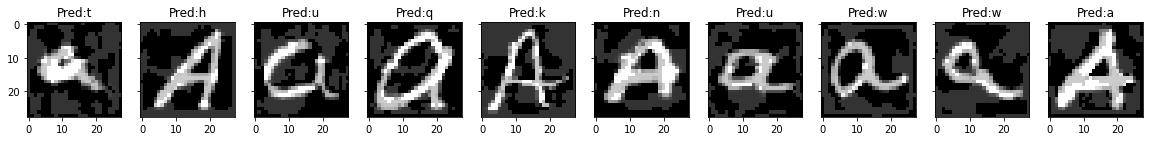

In [ ]:
# --------------> DBN <---------------
num_subplots = 10
n_cols = 10
n_rows = 1
fig, axes = plt.subplots(n_rows,n_cols, sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  col = i % n_cols
  test_image = emnist_test.data[i].reshape(1, 784)
  test_image.requires_grad_()
  # qui però ancora non si è verificato il disturbo al modello
  model_outputs = attacked_dbn(test_image)
  prediction = torch.argmax(model_outputs)
  epsilon = 0.2  # define strenght of the attack
  test_image_label = emnist_test.targets[i].unsqueeze(0) # get ground truth label for that image
  loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
  attacked_dbn.zero_grad()
  loss_value.backward()
  image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
  perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
  perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
  model_outputs = attacked_dbn(perturbed_image.view((perturbed_image.shape[0], -1)))
  ausiliare = torch.argmax(model_outputs).tolist()
  print(f"The prediction of the model for the perturbed sample is {label_changer(ausiliare)}.")
  axes[col].imshow(perturbed_image_np.reshape((28,28)).T, cmap=plt.cm.gray)
  axes[col].set_title(f"Pred:{label_changer(ausiliare)}")

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        
        data, target = data.to(device), target.to(device)
        target -= 1
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28).T,cmap=plt.cm.gray)
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T,cmap=plt.cm.gray)
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T,cmap=plt.cm.gray)
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', split= 'letters',train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

6.3 TOP DOWN RECONSTRUCTION AS A WAY TO MITIGATE THE EFFECT OF A.A.
Image reconstruction is a valid fix to adversarial attacks. In the following a top-down reconstruction will be performed.


In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 1.74%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2, 
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 23.49%



  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



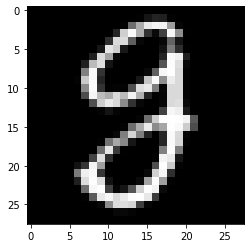


Here's a perturbed sample:



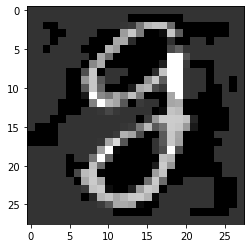


Here's what a 1-steps reconstructed sample looks like:



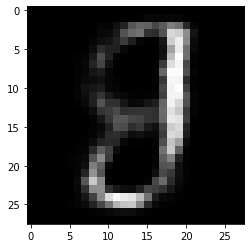


Epsilon: 0.2
Test Accuracy: 28.64%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=1)

6.2 VISUALIZE THE IMPACT OF ADVERSARIAL ATTACKS ON THE IMAGES
The letters of the dataset after the adversarial attack has been carried on look like this:


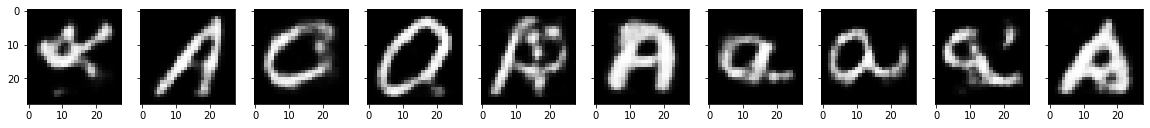

In [ ]:
attacked_dbn = dbn_with_readout
num_subplots = 10
n_cols = 10
n_rows = 1
fig, axes = plt.subplots(n_rows,n_cols, sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  col = i % n_cols
  #test_sample_idx = 2
  test_image = emnist_test.data[i].reshape(1, 784)
  #__ = plt.imshow(test_image.reshape(28,28).to('cpu'))
  test_image.requires_grad_()
  # qui però ancora non si è verificato il disturbo al modello
  model_outputs = attacked_dbn(test_image)
  prediction = torch.argmax(model_outputs)
  #print(f"The prediction of the model for this clean sample is {prediction}.")
  epsilon = 0.2  # define strenght of the attack
  test_image_label = emnist_test.targets[i].unsqueeze(0)  # get ground truth label for that image
  loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
  attacked_dbn.zero_grad()
  loss_value.backward()
  image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
  perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
  perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
  model_outputs = attacked_dbn(perturbed_image.view((perturbed_image.shape[0], -1)))
  disturbed_data, __ = attacked_dbn.dbn_emnist.reconstruct(perturbed_image)
  disturbed_data_0 = disturbed_data
  axes[col].imshow(disturbed_data_0.detach().to('cpu').numpy().reshape((28,28)).T, cmap=plt.cm.gray)

6.4 PSYCHOMETRICS CURVES 
Let’s now explore the robustness of each model to different attack strengths.


In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

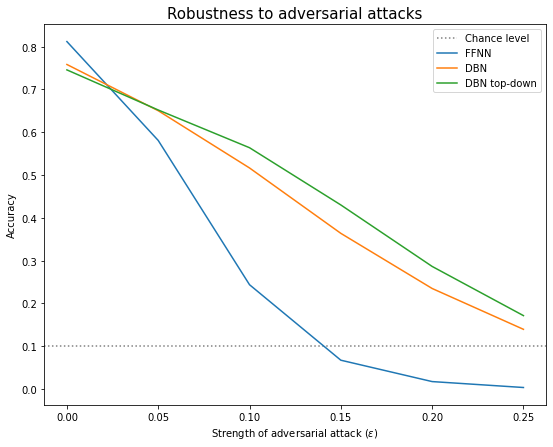

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

As the reconstructed images shown above
suggest, the model denoise the images
very well and this results in higher
accuracy and more resilience to
adversarial attacks.
Not only the DBN with top-down
reconstruction outperforms the FFNN but
it also outdoes the DBN without
reconstructions.
